In [10]:
import festim as F
import fenics as f
from fenics import *
from mshr import Rectangle, generate_mesh
import numpy as np
import matplotlib.pyplot as plt

Creating 2D mesh with FEniCS and marking its subdomains

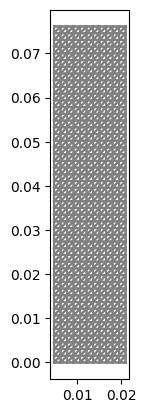

In [11]:
# creating a mesh with FEniCS
nx = round(50*(0.0162/0.0761))
ny = 50
nx2 = round(50*(0.00476/0.0761))
ny2 = round(50*(0.01/0.0761))
# mesh_fenics = UnitSquareMesh(nx, ny)

mesh_fenics = RectangleMesh(Point(0.00476, 0.0), Point(0.00476 + 0.0162, 0.0761), nx, ny)

plot(mesh_fenics)

# marking physical groups (volumes and surfaces)
volume_markers = MeshFunction(
    "size_t", mesh_fenics, mesh_fenics.topology().dim())
volume_markers.set_all(1)

left_surface = CompiledSubDomain(
    'on_boundary && near(x[0], 0, tol)', tol=1e-14)
right_surface = CompiledSubDomain(
    'on_boundary && near(x[0], 0.0162, tol)', tol=1e-14)
bottom_surface = CompiledSubDomain(
    'on_boundary && near(x[1], 0, tol)', tol=1e-14)
top_surface = CompiledSubDomain(
    'on_boundary && near(x[1], 0.0761, tol)', tol=1e-14)

surface_markers = MeshFunction(
    "size_t", mesh_fenics, mesh_fenics.topology().dim() - 1)
surface_markers.set_all(0)

# Surface ids
left_id = 1
top_id = 2
right_id = 3
bottom_id = 4
left_surface.mark(surface_markers, left_id)
right_surface.mark(surface_markers, right_id)
top_surface.mark(surface_markers, top_id)
bottom_surface.mark(surface_markers, bottom_id)

plot(mesh_fenics)

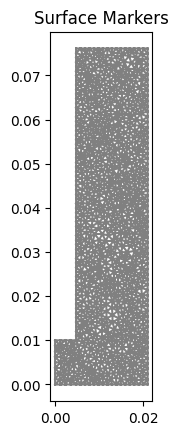

In [12]:
x1 = 0.00476
x2 = 0.0162
y1 = 0.01
y2 = 0.0761

p1 = f.Point(0, 0)
p2 = f.Point(x1, y1)
r1 = Rectangle(p1, p2)
p1 = f.Point(x1, 0)
p2 = f.Point(x1 + x2, y2)
r2 = Rectangle(p1, p2)
domain = r1 + r2
mesh_fenics = generate_mesh(domain, 40)

plot(mesh_fenics)

# marking physical groups (volumes and surfaces)
volume_markers = MeshFunction(
    "size_t", mesh_fenics, mesh_fenics.topology().dim())
volume_markers.set_all(1)

left_surface_str = f'on_boundary && near(x[0], {x1}, tol)'
left_surface = CompiledSubDomain(
    left_surface_str, tol=1e-14)

right_surface_str = f'on_boundary && near(x[0], {x1 + x2}, tol)'
right_surface = CompiledSubDomain(
    right_surface_str, tol=1e-14)

bottom_surface_str = f'on_boundary && near(x[1], 0, tol)'
bottom_surface = CompiledSubDomain(
    bottom_surface_str, tol=1e-14)

top_surface_str = f'on_boundary && near(x[1], {y2}, tol)'
top_surface = CompiledSubDomain(
    top_surface_str, tol=1e-14)

upper_left_surface_str = f'on_boundary && near(x[0], {x2}, tol)'
upper_left_surface = CompiledSubDomain(
    upper_left_surface_str, tol=1e-14)

left_top_surface_str = f'on_boundary && near(x[1], {y2}, tol)'
left_top_surface = CompiledSubDomain(
    left_top_surface_str, tol=1e-14)


surface_markers = MeshFunction(
    "size_t", mesh_fenics, mesh_fenics.topology().dim() - 1)
surface_markers.set_all(0)


# Surface ids
left_id = 1
top_id = 2
right_id = 3
bottom_id = 4
upper_left_id = 5
left_top_id = 6
left_surface.mark(surface_markers, left_id)
right_surface.mark(surface_markers, right_id)
top_surface.mark(surface_markers, top_id)
bottom_surface.mark(surface_markers, bottom_id)
upper_left_surface.mark(surface_markers, upper_left_id)
left_top_surface.mark(surface_markers, left_top_id)


plot(surface_markers, title="Surface Markers")


Functions defining flibe properties:

In [13]:
def density_flibe(T):
    return 2413 - 0.488 * T  # kg/m3


def viscosity_flibe(T):
    e = 2.718281828459045
    return 1.16e-04 * e ** (3755 / (T + DOLFIN_EPS))  # Pa.s


def beta_flibe(T):
    return 1.8319e-04 + 5.55e-08 * T  # K-1


def plot_properties():
    T = np.linspace(400, 1200, 1000)

    mu = viscosity_flibe(T)
    rho = density_flibe(T)
    beta = beta_flibe(T)

    plt.figure()
    mu *= 1e03
    plt.plot(T, mu, label="viscosity")
    plt.ylim(0, 30)
    plt.legend()

    plt.figure()
    plt.plot(T, rho, label="density")
    plt.ylim(1800, 2150)
    plt.legend()

    plt.figure()
    beta *= 1e04
    plt.plot(T, beta, label="Thermal expansion")
    plt.ylim(1.6, 2.8)
    plt.legend()

    plt.show()


CFD simulation function:

In [14]:

def velocity_field(T_cold, T_hot, my_mesh):
    """Computes the velocity field for a given mesh and temperature difference

    Args:
        T_cold (float): the cold temperature (right) in K
        T_hot (float): the hot temperature (left) in K
        my_mesh (fenics.Mesh): the mesh

    Returns:
        fenics.Function, fenics.Function, fenics.Function: velocity field (m/s), pressure (Pa), temperature (K)
    """
    T_bulk = ((T_hot - T_cold) / 2) + T_cold

    V_ele = VectorElement("CG", my_mesh.ufl_cell(), 2)
    Q_ele = FiniteElement("CG", my_mesh.ufl_cell(), 1)
    T_ele = FiniteElement("CG", my_mesh.ufl_cell(), 1)
    W = FunctionSpace(my_mesh, MixedElement([V_ele, Q_ele, T_ele]))

    upT = Function(W)
    upT_old = Function(W)
    u, p, T = split(upT)
    v, q, S = TestFunctions(W)

    for factor in [1e-03, 1e-02, 1e-01, 1]:
        print("Running for factor={:.1e}".format(factor))

        g = Constant((0, -9.81))  # gravity acceleration in m/s2
        mu = viscosity_flibe(T_bulk)  # dynamic viscosity in kg/m/s
        rho = density_flibe(T_bulk)  # density in kg/m3
        rho_0 = density_flibe(T_cold)  # density at T_cold
        cp = 2386  # heat capacity in J/(kg.K)
        thermal_cond = 1.1  # thermal conductivity in W/(m.K)
        beta = beta_flibe(T_bulk) * factor

        # CFD momentum
        F = (
            rho_0 * inner(dot(grad(u), u), v) * dx
            - inner(p, div(v)) * dx
            + mu * inner(grad(u), grad(v)) * dx
            + inner(rho_0 * beta * (T - T_bulk) * g, v) * dx
        )

        # CFD continuity
        F -= inner(q, div(u)) * dx

        # Heat transfer
        F += rho * cp * inner(dot(grad(T), u), S) * dx
        F += inner(thermal_cond * grad(T), grad(S)) * dx


        # Temperature boundary conditions
        upper_left_surface_TBC = DirichletBC(W.sub(2), T_hot, surface_markers, upper_left_id)
        left_top_surface_TBC = DirichletBC(W.sub(2), T_hot, surface_markers, left_top_id)
        right_surface_TBC = DirichletBC(W.sub(2), T_cold, surface_markers, right_id)

        # Non-slip NS boundary conditions
        upper_left_surface_VBC = DirichletBC(W.sub(0), Constant((0, 0)), surface_markers, upper_left_id)
        left_top_surface_VBC = DirichletBC(W.sub(0), Constant((0, 0)), surface_markers, left_top_id)
        right_surface_VBC = DirichletBC(W.sub(0), Constant((0, 0)), surface_markers, right_id)
        bottom_surface_VBC = DirichletBC(W.sub(0), Constant((0, 0)), surface_markers, bottom_id)

        # Non-slip through boundary conditions
        left_surface_VBC = DirichletBC(W.sub(0), Constant((0, 0)), surface_markers, left_id)
        top_surface_VBC = DirichletBC(W.sub(0), Constant((0, 0)), surface_markers, top_id)

        bcs = [
            upper_left_surface_TBC,
            left_top_surface_TBC,
            right_surface_TBC,
            upper_left_surface_VBC,
            left_top_surface_VBC,
            right_surface_VBC,
            bottom_surface_VBC,
            left_surface_VBC,
            top_surface_VBC
        ]

        # # Old boundary conditions
        # bcs = [
        #     DirichletBC(W.sub(0), Constant((0, 0)), "on_boundary"),
        #     DirichletBC(W.sub(2), T_hot, "on_boundary && x[0] == 0"),
        #     DirichletBC(W.sub(2), T_cold, "on_boundary && x[0] == 0.0162"),
        # ]

        solve(
            F == 0,
            upT,
            bcs=bcs,
            solver_parameters={
                "newton_solver": {
                    "linear_solver": "mumps",
                    "absolute_tolerance": 1e-09,
                    "relative_tolerance": 1e-09,
                    "maximum_iterations": 25,
                }
            },
        )

        upT_old.assign(upT)

    u, p, T = upT.split()

    return u, p, T


Cylindrical Representation Class

In [ ]:
class AverageVolumeCylindrical(VolumeQuantity):
    def compute(self):

        mesh = self.function.function_space().mesh()  # get the mesh from the function
        rthetaz = f.SpatialCoordinate(mesh)  # get the coordinates from the mesh
        r = rthetaz[0]  # only care about r here

        return f.assemble(r * self.function * self.dx(self.volume)) / f.assemble(
            r * self.dx(self.volume)
        )
class SurfaceFluxCylindrical(SurfaceFlux):
    def __init__(self, field, surface) -> None:
        super().__init__(field, surface)
        self.r = None

    def compute(self, soret=False):
        if soret:
            raise NotImplementedError(
                "Soret effect not implemented for cylindrical coordinates"
            )

        if self.r is None:
            mesh = (
                self.function.function_space().mesh()
            )  # get the mesh from the function
            rthetaz = f.SpatialCoordinate(mesh)  # get the coordinates from the mesh
            self.r = rthetaz[0]  # only care about r here

        # dS_z = r dr dtheta , assuming axisymmetry dS_z = theta r dr
        # dS_r = r dz dtheta , assuming axisymmetry dS_r = theta r dz
        # in both cases the expression with self.ds is the same
        # we assume full cylinder theta = 2 pi
        flux = f.assemble(
            self.prop
            * self.r
            * f.dot(f.grad(self.function), self.n)
            * self.ds(self.surface)
        )
        theta = 2 * np.pi
        flux *= theta
        return flux

Diffusion Simulation:

In [15]:
def my_simulation(temperature_field, mesh_fenics, velocity):
    """
    Takes in a list of temperatures and a set mesh and returns a list of diffusion coefficients that correspond to each temperature

    Args:
        temperature_field (fenics.Function): the temperature field in K
        mesh_fenics (fenics.Mesh): the mesh (should be the same as the one used to compute the temperature field)
        velocity (fenics.Function): the velocity field in m/s

    Returns:
        float: the mass transport coefficient in m/s
    """
    # setting up current simulation
    model_2d = F.Simulation()

    # D, E_d source: "nakamura_hydrogen_2015"
    # Thermal cond source: https://dspace.mit.edu/bitstream/handle/1721.1/123988/Romatoski_SaltPropertyReview02.pdf?sequence=1&isAllowed=y#:~:text=From%20the%20data%20collected%2C%20the,an%20uncertainty%20of%20%C2%B110%25.
    flibe_mat = F.Material(
        id=1,
        D_0=1.508521565198744e-08,
        E_D=0.23690444592353738,
        # thermal_cond=1.1  #  <--- not needed here
        )
    model_2d.materials = F.Materials([flibe_mat])

    # creating mesh with festim
    model_2d.mesh = F.Mesh(
        mesh=mesh_fenics,  # TODO we should be able to get the mesh from the temperature field
        volume_markers=volume_markers,
        surface_markers=surface_markers
    )

    # setting up steady state heat transfer problem

    # model_2d.T = F.TemperatureFromXDMF(temperature_file, label="temperature")
    model_2d.T = F.Temperature(value=973)  # dummy temperature, will be overwritten later


    # setting up T source
    model_2d.sources = [
        F.Source(
            value=1.84*10**5/(0.0761*0.0162), 
            volume=1, 
            field=0
            )
        ]

    
    # setting up transport boundary conditions
    tritium_transport_bcs = [
        F.DirichletBC(
            surfaces=[top_id, bottom_id, right_id, left_top_id, left_id, upper_left_id], 
            value=0, 
            field=0
            )
    ]

    model_2d.boundary_conditions = tritium_transport_bcs

    
    # simulation parameters and running model
    model_2d.settings = F.Settings(
        transient=False,
        absolute_tolerance=1e-09,
        relative_tolerance=1e-09,
    )

    # setting up exports
    export_folder = "BABY_2D_results"

    derived_quantities = F.DerivedQuantities(filename=export_folder + "/simulation.csv")

    derived_quantities.derived_quantities = [
        F.SurfaceFlux(field="solute", surface=left_id),
        F.SurfaceFlux(field="solute", surface=right_id),
        F.SurfaceFlux(field="solute", surface=top_id),
        F.SurfaceFlux(field="solute", surface=bottom_id),
        F.SurfaceFlux(field="solute", surface=upper_left_id),
        F.SurfaceFlux(field="solute", surface=left_top_id),
        F.AverageVolume(field="solute", volume=1)
        ]

    model_2d.exports = F.Exports([
        F.XDMFExport("solute", folder=export_folder),
        F.XDMFExport("retention", folder=export_folder),
        F.XDMFExport("T", folder=export_folder),
        derived_quantities
        ])
    # adding advection
    model_2d.initialise() # reinitialisation is needed

    model_2d.T.T = temperature_field
    model_2d.T.T_n = temperature_field  # don't know if this is needed

    hydrogen_concentration = model_2d.h_transport_problem.mobile.solution
    test_function_solute = model_2d.h_transport_problem.mobile.test_function

    advection_term = inner(dot(grad(hydrogen_concentration), velocity), test_function_solute) * model_2d.mesh.dx

    model_2d.h_transport_problem.F += advection_term

    model_2d.run()

    plt.figure()
    plt.title("Hydrogen concentration")
    CS = plot(hydrogen_concentration)
    plot(velocity, scale=1e-3, color="black", alpha=0.5)
    plt.colorbar(CS, label="H/m3")
    plt.show()
    

    # reading results
    my_data = np.genfromtxt(export_folder + "/simulation.csv", names=True, delimiter=",")

    flux_1 = my_data["Flux_surface_1_solute"]
    flux_2 = my_data["Flux_surface_2_solute"]
    flux_3 = my_data["Flux_surface_3_solute"]
    flux_4 = my_data["Flux_surface_4_solute"]

    # calculating diffusion coefficient
    total_flux = abs(flux_1 + flux_2 + flux_3 + flux_4)

    average_conc = my_data["Average_solute_volume_1"]

    A = 0.0761*0.0162  # m2
    k = total_flux/(A*average_conc)

    print(f"Total flux: {total_flux} H/s/m")
    print(f"Average concentration: {average_conc} H/m3")
    print(f"k: {k} /s  (double check the units)")

    return k

----------  Running for dT=1 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00


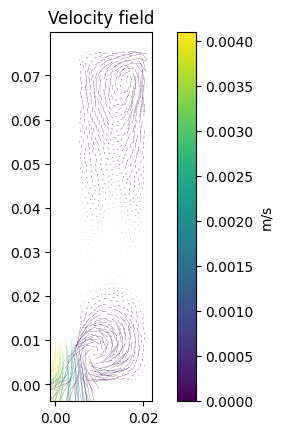

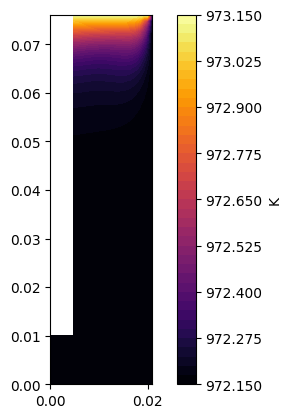

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


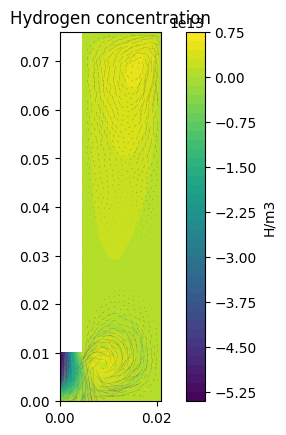

Total flux: 109811.68001634566 H/s/m
Average concentration: 868435543157.4082 H/m3
k: 0.0001025678553545395 /s  (double check the units)


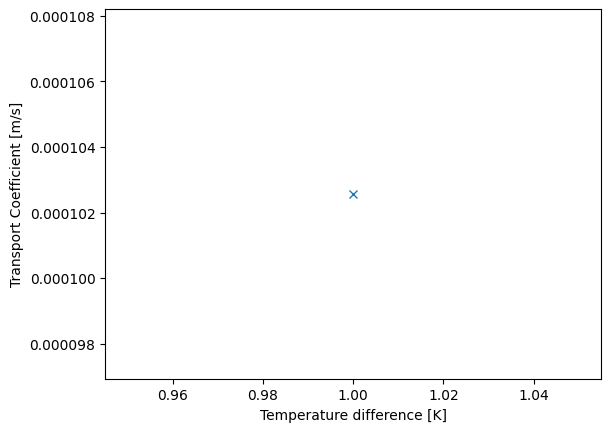

In [16]:
if __name__ == "__main__":
    T_hot = 700 + 273.15

    dt_array = [1]
    k_array = []
    for dT in dt_array:
        print(f"----------  Running for dT={dT} K  ----------")
        foldername = f"Results/dt={dT}/"
        T_cold = T_hot - dT
        u, p, T = velocity_field(T_cold=T_cold, T_hot=T_hot, my_mesh=mesh_fenics)

        XDMFFile(foldername + "temperature_field.xdmf").write_checkpoint(T, "temperature", 1, XDMFFile.Encoding.HDF5)
        XDMFFile(foldername + "velocity_field.xdmf").write(u)

        plt.figure()
        plt.title("Velocity field")
        CS = plot(u, scale=1e-3)
        plt.colorbar(CS, label="m/s")
        plt.show()

        plt.figure()
        TS = plot(T, cmap="inferno")
        plt.colorbar(TS, label="K")
        plt.show()

        k = my_simulation(T, mesh_fenics, u)
        k_array.append(k)

    plt.plot(dt_array, k_array, '-x', linewidth=3)
    plt.xlabel("Temperature difference [K]")
    plt.ylabel("Transport Coefficient [m/s]")